## Get information from omdb api for each title

### Get a list of movie titles from the last 10 years

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re 
from sklearn import cross_validation as cv
from sklearn import metrics
import sklearn
from sklearn import preprocessing
%matplotlib inline

In [2]:
url_list = []
for year in range(2006, 2016):
    url = "http://www.wildaboutmovies.com/%d_movies/" % year
    url_list.append(url)

In [3]:
def get_titles(url_list):
    titles = []
    for url in url_list:
        soup = BeautifulSoup(requests.get(url).text)
        images = soup.find_all("img")
        # get title for each image except for the first two ones and the last one, which are not a movies
        for image in images[2:len(images) - 1]:
            title = image['alt']
            titles.append(title)
    return titles


In [4]:
all_titles = get_titles(url_list)

In [85]:
len(all_titles)

3027

We have 3027 movie titles

### Get a list of the api urls from the list of movie titles

In [86]:
def get_urls(movie_titles):
    api_urls = []
    # get url to query api 
    for title in movie_titles: 
        title_format = title.replace(" ", "+")
        api_url = "http://www.omdbapi.com/?t=%s&y=&plot=full&r=json&tomatoes=true" % title_format
        api_urls.append(api_url)
    return api_urls

In [87]:
all_urls = get_urls(all_titles)

In [88]:
all_urls[0:10]

['http://www.omdbapi.com/?t=Glory+Road&y=&plot=full&r=json&tomatoes=true',
 'http://www.omdbapi.com/?t=Last+Holiday&y=&plot=full&r=json&tomatoes=true',
 'http://www.omdbapi.com/?t=Underworld+2:+Evolution&y=&plot=full&r=json&tomatoes=true',
 'http://www.omdbapi.com/?t=Annapolis&y=&plot=full&r=json&tomatoes=true',
 'http://www.omdbapi.com/?t=Imagine+Me+&+You&y=&plot=full&r=json&tomatoes=true',
 'http://www.omdbapi.com/?t=Manderlay&y=&plot=full&r=json&tomatoes=true',
 'http://www.omdbapi.com/?t=Something+New&y=&plot=full&r=json&tomatoes=true',
 'http://www.omdbapi.com/?t=When+A+Stranger+Calls&y=&plot=full&r=json&tomatoes=true',
 'http://www.omdbapi.com/?t=Curious+George&y=&plot=full&r=json&tomatoes=true',
 'http://www.omdbapi.com/?t=Final+Destination+3&y=&plot=full&r=json&tomatoes=true']

### From the list of api urls, get a dataframe with all that information for all movies

In [89]:
def movie_info(api_urls):
    # get one results so we can set index of that as column of movie_df, which will be what we return 
    response_prc = requests.get(api_urls[0])
    page_prc = response_prc.json()
    movie_info_prc = pd.Series(page_prc) 
    movie_df = pd.DataFrame(columns = movie_info_prc.index)
    # set a bad url so we can skip any bad_urls in our api_urls list 
    bad_url = "http://www.omdbapi.com/?t=no+movie+is+called+this&y=&plot=short&r=json"
    bad_response = requests.get(bad_url)
    bad_page = bad_response.json()
    # query api and get resulting information in series
    for api_url in api_urls[1:]: 
        response = requests.get(api_url)
        page = response.json()
        # only continue if url api request worked
        if page != bad_page: 
            movie_info = pd.Series(page) 
            movie_df = movie_df.append(movie_info, ignore_index = True)
    return movie_df

In [90]:
movie_df = movie_info(all_urls)

## Pickle the dataframe

In [91]:
import pickle

with open('movie_data.pkl', 'w') as picklefile:
    pickle.dump(movie_df, picklefile)

In [92]:
len(movie_df)

2738

Some of the movies were not in the omdb api, so our movie_df is only 2738 versus 3027

### Import pickled data if needed

In [467]:
with open("movie_data.pkl", 'r') as picklefile: 
    movie_df = pickle.load(picklefile)

In [525]:
merged_movies.columns

Index([u'Actors', u'Awards', u'Country', u'DVD', u'Director', u'Genre', u'Language', u'Metascore', u'Plot', u'Poster', u'Production', u'Rated', u'Released', u'Response', u'Runtime', u'Title', u'Type', u'Website', u'Writer', u'Year', u'imdbID', u'imdbRating', u'imdbVotes', u'tomatoConsensus', u'tomatoFresh', u'tomatoImage', u'tomatoMeter', u'tomatoRating', u'tomatoReviews', u'tomatoRotten', u'tomatoURL', u'tomatoUserMeter', u'tomatoUserRating', u'tomatoUserReviews', u'totalSeasons', u'Error', u'Release Date', u'Movie', u'Production Budget', u'Domestic Gross', u'Worldwide Gross', u'tomatoRatingDif', u'Nominations', u'Wins', u'Foreign Gross', u'Oscars'], dtype='object')

## Clean up our movie dataset

### Check for duplicate entries

In [468]:
# mask_dup is true when rows are exactly the same as a previous row
mask_dup = movie_df.duplicated()
movie_df1 = movie_df[~mask_dup] # this is the dataset without the duplciates row
print len(movie_df) - len(movie_df1)

41


We had 41 rows duplicate rows. Let's take a look at those

In [469]:
movie_duplicates = movie_df[mask_dup]
movie_duplicates

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoMeter,tomatoRating,tomatoReviews,tomatoRotten,tomatoURL,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,totalSeasons,Error
87,"Riz Ahmed, Farhad Harun, Waqar Siddiqui, Arfan...",4 wins & 6 nominations.,N/A,UK,24 Oct 2006,"Mat Whitecross, Michael Winterbottom","Documentary, Drama, War","English, Urdu",64,"Part drama, part documentary, The Road to Guan...",...,86,7.1,95,13,http://www.rottentomatoes.com/m/road_to_guanta...,82,3.4,27013,NaN,NaN
118,"Aaron Eckhart, Helena Bonham Carter, Yury Tsyk...",3 wins & 4 nominations.,N/A,"UK, USA",09 Jan 2007,Hans Canosa,"Comedy, Drama, Romance",English,62,A man runs into a woman at a wedding. They sta...,...,74,6.5,62,16,http://www.rottentomatoes.com/m/conversations_...,76,3.6,11941,NaN,NaN
179,"Brad Pitt, Cate Blanchett, Mohamed Akhzam, Pet...",Won 1 Oscar. Another 41 wins & 128 nominations.,N/A,"France, USA, Mexico",20 Feb 2007,Alejandro G. Iñárritu,Drama,"English, Arabic, Spanish, Japanese, Berber lan...",69,4 interlocking stories all connected by a sing...,...,69,6.7,195,60,http://www.rottentomatoes.com/m/babel/,77,3.5,376469,NaN,NaN
185,"Diane Kruger, Ralph Riach, Matyelok Gibbs, Ed ...",2 wins & 5 nominations.,N/A,"USA, Germany, Hungary",03 Apr 2007,Agnieszka Holland,"Biography, Drama, Music",English,59,"Vienna, 1824. In the days before the first per...",...,28,4.8,81,58,http://www.rottentomatoes.com/m/copying_beetho...,57,3.2,14167,NaN,NaN
222,"Owen Wilson, Paul Newman, Bonnie Hunt, Larry t...",Nominated for 2 Oscars. Another 27 wins & 28 n...,N/A,USA,07 Nov 2006,"John Lasseter, Joe Ranft","Animation, Adventure, Comedy","Yiddish, English, Italian, Japanese",73,A hot-shot race-car named Lightning McQueen ge...,...,74,6.9,196,51,http://www.rottentomatoes.com/m/cars/,80,3.7,875666,NaN,NaN
223,"Hugh Jackman, Halle Berry, Ian McKellen, Patri...",7 wins & 37 nominations.,N/A,"Canada, USA, UK",03 Oct 2006,Brett Ratner,"Action, Adventure, Fantasy",English,58,"When a cure is created, which apparently can t...",...,58,5.9,232,98,http://www.rottentomatoes.com/m/x_men_3_the_la...,62,3.6,1072050,NaN,NaN
224,"Tom Hanks, Audrey Tautou, Ian McKellen, Jean Reno",Nominated for 1 Golden Globe. Another 5 wins &...,N/A,"USA, Malta, France, UK",14 Nov 2006,Ron Howard,"Mystery, Thriller","English, French, Latin, Spanish",46,Professor Robert Langdon is in Paris on busine...,...,25,4.8,221,166,http://www.rottentomatoes.com/m/da_vinci_code/,57,3.2,760286,NaN,NaN
225,"Brandon Routh, Kate Bosworth, Kevin Spacey, Ja...",Nominated for 1 Oscar. Another 12 wins & 38 no...,N/A,USA,28 Nov 2006,Bryan Singer,"Action, Adventure, Sci-Fi","English, German, French",72,Following a mysterious absence of several year...,...,76,7.0,258,63,http://www.rottentomatoes.com/m/superman_returns/,61,3.3,516001,NaN,NaN
226,"Carlos Alazraqui, Lombardo Boyar, Jeffrey Garc...",Won 1 Oscar. Another 18 wins & 24 nominations.,N/A,"USA, Australia",27 Mar 2007,"George Miller, Warren Coleman, Judy Morris","Animation, Comedy, Family",English,77,This is the story of a little penguin named Mu...,...,75,6.9,161,41,http://www.rottentomatoes.com/m/happy_feet/,70,3.6,616509,NaN,NaN
227,"Andrew Bowen, Grey Griffin, Jess Harnell, Deni...",1 nomination.,N/A,USA,N/A,Carlos Saldanha,Action,English,N/A,This game is a spin-off of the film Ice Age: T...,...,N/A,N/A,N/A,N/A,http://www.rottentomatoes.com/m/ice-games/,N/A,N/A,265,NaN,NaN


One is called "babel". Let's see if duplicate was in title list

In [5]:
ind = [i for i, x in enumerate(all_titles) if x == "Babel"]
print ind

[188, 189]


Yes duplciate was in initial list of titles. Checking out 2006 movie url for Babel, it seems duplicate is on the movie site's side. So we can just drop duplicates without worrying

In [470]:
movie_df = movie_df1
print len(movie_df)

2697


**movie_df now has no duplicates**

### Fix "N/As"

In [471]:
# Change any "N/A" to None so panda can recognize it as none
movie_df = movie_df.applymap(lambda x: np.nan if x == "N/A" else x)

**movie_df now has correct values for null**

### Delete tv seasons (where "totalSeasons" is not null)

In [472]:
mask = pd.isnull(movie_df["totalSeasons"])
# make movie_5 a dataset where totalSeasons is null 
movie_df = movie_df[mask]

In [473]:
len(movie_df)

2679

**movie_df now has no tv shows**

### Check how many missing box office information 

In [474]:
print pd.isnull(movie_df['BoxOffice']).sum()

2656


Well that's an issue! Almost no movies have box office data. We'll have to collect more data

## Get information on budget from the-number

A great trick when trying to get a table from a website is to first try with pandas to see if pandas can automatically extract the table, rather than reading through the html and using beautifulsoup. 

In [7]:
# extract a table from the page with movie budgets
with open("The Numbers - Movie Budgets.htm", 'r') as fh:
    tables = pd.read_html(fh.read())

In [8]:
print len(tables)

1


Pandas gave us back only one table. 

In [476]:
tables = tables[0]
type(tables)

pandas.core.frame.DataFrame

In [477]:
# delete rows that are just NAs
budget_info = tables.dropna(how = "all").reset_index()
# drop first two columns 
budget_info = budget_info.drop(budget_info.columns[[0, 1]], axis=1)
# make first row the column names and drop it
budget_info.columns = budget_info.iloc[0]
budget_info = budget_info.reindex(budget_info.index.drop(0))
print len(budget_info)
budget_info[0:5]

5154


,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
1,12/18/2009,Avatar,"$425,000,000","$760,507,625","$2,783,918,982"
2,12/18/2015,Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,058,662,225"
3,5/24/2007,Pirates of the Caribbean: At World's End,"$300,000,000","$309,420,425","$963,420,425"
4,11/6/2015,Spectre,"$300,000,000","$200,074,175","$879,620,923"
5,7/20/2012,The Dark Knight Rises,"$275,000,000","$448,139,099","$1,084,439,099"


**Now we have budget_info, which is budget information for movies**

### Merge budget_info into movie_df

In [478]:
merged_movies = movie_df.merge(budget_info, how = "left", left_on = "Title", right_on = "Movie")
merged_movies[0:3]

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,...,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,totalSeasons,Error,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross
0,"Queen Latifah, LL Cool J, Timothy Hutton, Gian...",7 nominations.,NaN,USA,02 May 2006,Wayne Wang,"Adventure, Comedy, Drama","French, English",52,In morte veritas. Georgia Byrd clerks at a New...,...,67,3.3,372824,NaN,NaN,1/13/2006,Last Holiday,"$45,000,000","$38,399,961","$43,343,247"
1,"James Franco, Macka Foley, Jim Parrack, Donnie...",NaN,NaN,USA,27 Jun 2006,Justin Lin,"Drama, Romance, Sport",English,37,"Jake Huard, from a shipbuilders family, promis...",...,60,3.2,119177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,USA,NaN,Michael Cox,"Short, Drama",English,NaN,A teenage boy is mortified when his mother cat...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [479]:
merged_movies.columns

Index([u'Actors', u'Awards', u'BoxOffice', u'Country', u'DVD', u'Director', u'Genre', u'Language', u'Metascore', u'Plot', u'Poster', u'Production', u'Rated', u'Released', u'Response', u'Runtime', u'Title', u'Type', u'Website', u'Writer', u'Year', u'imdbID', u'imdbRating', u'imdbVotes', u'tomatoConsensus', u'tomatoFresh', u'tomatoImage', u'tomatoMeter', u'tomatoRating', u'tomatoReviews', u'tomatoRotten', u'tomatoURL', u'tomatoUserMeter', u'tomatoUserRating', u'tomatoUserReviews', u'totalSeasons', u'Error', u'Release Date', u'Movie', u'Production Budget', u'Domestic Gross', u'Worldwide Gross'], dtype='object')

Now check how many of merged_movies have production budget information

In [480]:
print pd.isnull(merged_movies['Production Budget']).sum()

1536


In [481]:
# Drop "BoxOffice" variable, which was in the original dataset and almost always missing
del merged_movies["BoxOffice"]

#### Change budget information to float

In [482]:
merged_movies[["Production Budget", "Domestic Gross", "Worldwide Gross"]] = merged_movies[["Production Budget", "Domestic Gross", "Worldwide Gross"]].astype(str)
# get rid of dollar sign and commas
merged_movies[["Production Budget", "Domestic Gross", "Worldwide Gross"]] = merged_movies[["Production Budget", "Domestic Gross", 
                                                                                           "Worldwide Gross"]].applymap(lambda x: re.sub("[,\$]", "", x) 
                                                                                                                        if type(x) == str else x)
# make columns floats
merged_movies[["Production Budget", "Domestic Gross", "Worldwide Gross"]] =merged_movies[["Production Budget", "Domestic Gross", "Worldwide Gross"]].astype(float)

#### Create "Foreign Gross" column

In [483]:
merged_movies["Foreign Gross"] = merged_movies["Worldwide Gross"] - merged_movies["Domestic Gross"]

In [502]:
merged_movies.rename(columns={'Domestic Gross': 'Domestic_Gross', 'Foreign Gross': 'Foreign_Gross', 
                              "Production Budget": "Production_Budget", "Worldwide Gross": "Worldwide_Gross"}, inplace=True)

**Now we have merged_movies, which includes budget and gross for 1536 movies of 2694**

## Change runtime column to just digits

In [485]:
merged_movies["Runtime"] = merged_movies["Runtime"].astype(str)
# extract digits
merged_movies["Runtime"] = merged_movies["Runtime"].apply(lambda x: re.sub("\D", "", x))
merged_movies["Runtime"] = merged_movies["Runtime"].apply(lambda x: int(x) if x != "" else np.nan)

In [486]:
merged_movies["Runtime"][0:5]

0    112
1    108
2      8
3    139
4     99
Name: Runtime, dtype: float64

## Split genre column 

In [369]:
merged_movies["Genre"] = merged_movies["Genre"].astype("str")
genres = merged_movies["Genre"].str.split(',', return_type='frame')
# strip spaces
genres = genres.astype(str)
genres = genres.applymap(lambda x: x.strip())

In [370]:
# Change "nan" to null 
genres = genres.applymap(lambda x: np.nan if x == "nan" else x)

In [371]:
genres.columns = ['Primary_Genre', 'Secondary_Genre', "Third_Genre"]
print 1 - float(genres["Third_Genre"].isnull().sum())/len(genres)

0.48292501856


So we can see movies have at most 3 genres, and about 48% have three genres. 

Make a column with the primary genre

In [351]:
genres['Primary_Genre'].value_counts()

Comedy         694
Drama          616
Action         355
Documentary    315
Crime          170
Biography      121
Adventure      116
Animation      104
Horror          94
Short           32
Fantasy         18
Thriller        12
Mystery         10
Family           9
Sci-Fi           7
Romance          3
Musical          2
Music            2
Adult            2
Talk-Show        1
History          1
Western          1
Reality-TV       1
dtype: int64

In [272]:
genres['Secondary_Genre'].value_counts()

Drama          643
Romance        225
Crime          169
Adventure      164
Comedy         160
Thriller       120
Horror         104
Mystery         85
Biography       68
Family          64
Fantasy         61
Music           58
History         46
Sci-Fi          39
Sport           37
Action          21
War             20
Short           18
Musical          9
Western          4
Film-Noir        2
News             2
Animation        1
Documentary      1
dtype: int64

In [273]:
genres["Third_Genre"].value_counts()

Thriller     262
Romance      204
Drama        164
Mystery       78
Fantasy       75
Sci-Fi        73
Family        70
Comedy        68
History       54
Sport         48
Horror        45
Crime         45
Music         43
War           29
Adventure     12
Musical        9
Western        9
Biography      7
News           5
Action         1
dtype: int64

Let's clean out any genre that doesn't appear more than 5 times in any of the columns

In [352]:
# First we make one long series of all the columns
all_genres = genres["Primary_Genre"].append(genres["Secondary_Genre"]).append(genres["Third_Genre"])
all_genres = all_genres.to_frame(name = "genres")
all_genres["genres"].value_counts()

Drama          1423
Comedy          922
Romance         432
Thriller        394
Crime           384
Action          377
Documentary     316
Adventure       292
Horror          243
Biography       196
Mystery         173
Fantasy         154
Family          143
Sci-Fi          119
Animation       105
Music           103
History         101
Sport            85
Short            50
War              49
Musical          20
Western          14
News              7
Film-Noir         2
Adult             2
Talk-Show         1
Reality-TV        1
dtype: int64

In [549]:
high_count = np.array(df['c1'].value_counts()[mask].index)
small_genres = all_genres[all_genres.groupby('genres').genres.transform(len) < 20]
small_genres = set(small_genres)

In [550]:
genres['Primary_Genre'] = ["Other" if i in small_genres else i for i in genres['Primary_Genre']]
genres['Secondary_Genre'] = ["Other" if i in small_genres else i for i in genres['Secondary_Genre']]
genres['Third_Genre'] = ["Other" if i in small_genres else i for i in genres['Third_Genre']]

In [551]:
genres['Primary_Genre'].value_counts()

Comedy         694
Drama          616
Action         355
Documentary    315
Crime          170
Biography      121
Adventure      116
Animation      104
Horror          94
Short           32
Fantasy         18
Thriller        12
Mystery         10
Family           9
Sci-Fi           7
Romance          3
Musical          2
Music            2
History          1
dtype: int64

Now let's change any movie genres with less than 20 instances to NaN

In [373]:
sg = small_genres['genres'].tolist()
genres = genres.applymap(lambda x: x if x not in sg else np.nan)
print genres["Primary_Genre"].unique()

['Adventure' 'Drama' 'Short' 'Comedy' 'Horror' 'Animation' 'Crime'
 'Fantasy' 'Action' 'Biography' 'Documentary' 'Mystery' 'Family' nan
 'Sci-Fi' 'Thriller' 'Romance' 'Musical' 'History' 'Music']


In [588]:
merged_movies["Primary_Genre"] = genres['Primary_Genre']
merged_movies["Secondary_Genre"] = genres['Secondary_Genre']

Now we have a "primary genre" and a "secondary genre" column 

### Check how many movies have rating information

#### Check rotten tomato information

In [119]:
print pd.isnull(merged_movies['tomatoRating']).sum()
print pd.isnull(merged_movies['tomatoFresh']).sum()
print pd.isnull(merged_movies['tomatoImage']).sum()
print pd.isnull(merged_movies['tomatoMeter']).sum()

304
304
304
352


So about 304 movies are missing rotten tomato critics reviews

In [120]:
print pd.isnull(merged_movies['tomatoUserRating']).sum()
print pd.isnull(merged_movies['tomatoUserReviews']).sum()
print pd.isnull(merged_movies['tomatoUserMeter']).sum()

154
115
154


So about 154 are missing user review information. Sometimes they have user review number but no information on those reviews (e.g. https://www.rottentomatoes.com/m/we-r-friends), which is why there are fewer missing values for "tomatoUserReview." But knowing the number of reviews with no information on what the ratings are isn't very helpful. 

In [9]:
# look at entries where user information missing
tf_missing_ur = pd.isnull(merged_movies['tomatoUserRating'])
missing_user_ratings = [i for i, x in enumerate(tf_missing_ur) if x]
missing_ur = merged_movies.iloc[missing_user_ratings]
missing_ur[1:4]

NameError: name 'merged_movies' is not defined

#### Check metacritic information

In [48]:
print pd.isnull(merged_movies['Metascore']).sum()

416


Missing 416 metacritic scores

This is the critics' score

#### Check imdb information

In [49]:
print pd.isnull(merged_movies['imdbRating']).sum()
print pd.isnull(merged_movies['imdbVotes']).sum()

32
32


Only missing 32 information on imdb Ratings

## Split up awards columns into awards and nominations into two columns and make numbers, not strings

In [487]:
merged_movies["Awards"] = merged_movies["Awards"].astype("str")
# separates can be "." (in the case of Oscars) or "&"
awards_noms = merged_movies["Awards"].str.split("[.&]+", return_type='frame')

In [489]:
print awards_noms[0].unique()

['7 nominations' 'nan' '1 win ' '4 wins ' '3 nominations' '1 nomination'
 '6 nominations' '2 wins ' '4 nominations' 'Won 1 Oscar' '2 nominations'
 '5 nominations' 'Nominated for 2 Golden Globes' '7 wins ' '5 wins '
 '3 wins' '10 wins ' 'Nominated for 1 Golden Globe' '8 nominations'
 '41 wins ' '12 wins ' '3 wins ' 'Nominated for 2 Oscars'
 'Nominated for 1 Oscar' '6 wins ' 'Won 2 Oscars' '4 wins' '1 win'
 '8 wins ' 'Nominated for 3 Oscars' 'Won 4 Oscars' '2 wins'
 'Nominated for 1 BAFTA Film Award' 'Won 1 BAFTA Film Award'
 'Nominated for 2 BAFTA Film Awards' 'Nominated for 5 Oscars'
 'Won 1 Golden Globe' 'Nominated for 4 Oscars' '6 wins' '9 nominations'
 '16 wins ' '11 wins ' '13 wins ' '9 wins ' 'Won 3 Oscars' '25 wins '
 '14 nominations' '11 nominations' '12 nominations' '17 wins ' '10 wins'
 '32 wins ' '22 wins ' '14 wins' 'Nominated for 3 Golden Globes' '24 wins '
 '13 nominations' '15 wins ' '19 wins ' 'Won 2 Primetime Emmys' '21 wins '
 '39 wins ' '8 wins' '15 wins' '14 wins ' '

In [490]:
# make entry in fist column na if has "golden globe" or "oscar" or "BAFTA" or "Emmy" 
big_awards = ["Oscar", "Golden Globe", "BAFTA", "Emmy"]
words_re = re.compile("|".join(big_awards))
awards_noms[0] = awards_noms[0].apply(lambda x: np.nan if words_re.search(x) else x)
awards_noms[0].unique()

array(['7 nominations', 'nan', '1 win ', '4 wins ', '3 nominations',
       '1 nomination', '6 nominations', '2 wins ', '4 nominations', nan,
       '2 nominations', '5 nominations', '7 wins ', '5 wins ', '3 wins',
       '10 wins ', '8 nominations', '41 wins ', '12 wins ', '3 wins ',
       '6 wins ', '4 wins', '1 win', '8 wins ', '2 wins', '6 wins',
       '9 nominations', '16 wins ', '11 wins ', '13 wins ', '9 wins ',
       '25 wins ', '14 nominations', '11 nominations', '12 nominations',
       '17 wins ', '10 wins', '32 wins ', '22 wins ', '14 wins',
       '24 wins ', '13 nominations', '15 wins ', '19 wins ', '21 wins ',
       '39 wins ', '8 wins', '15 wins', '14 wins ', '20 wins ', '5 wins',
       '23 wins ', '19 wins', '18 wins ', '30 wins ', '35 wins ',
       '16 nominations', '29 wins ', '11 wins', '27 wins ', '28 wins ',
       '9 wins'], dtype=object)

In [457]:
print awards_noms[1].unique()
print awards_noms[2].unique()
print awards_noms[3].unique()

['' nan ' 15 nominations' ' 10 nominations' ' 1 nomination'
 ' 2 nominations' ' 3 nominations' ' 4 nominations' ' Another 16 wins '
 ' 5 nominations' ' Another 12 wins ' ' 27 nominations' ' 6 nominations'
 ' 13 nominations' ' Another 1 win ' ' 14 nominations' ' Another 27 wins '
 ' Another 6 nominations' ' 19 nominations' ' Another 5 wins '
 ' Another 30 wins ' ' 37 nominations' ' Another 3 wins ' ' 20 nominations'
 ' 11 nominations' ' 7 nominations' ' 18 nominations' ' Another 4 wins '
 ' Another 68 wins ' ' 9 nominations' ' 8 nominations' ' Another 10 wins '
 ' 12 nominations' ' Another 47 wins ' ' Another 18 wins '
 ' Another 90 wins ' ' Another 15 wins ' ' Another 41 wins '
 ' Another 20 wins ' ' Another 6 wins ' ' Another 60 wins '
 ' Another 28 wins ' ' Another 7 wins ' ' Another 25 wins '
 ' Another 2 wins ' ' Another 8 wins ' ' Another 3 nominations'
 ' Another 11 wins ' ' Another 23 wins ' ' Another 14 wins '
 ' Another 75 wins ' ' 64 nominations' ' 42 nominations'
 ' Another 

So 4th column has nothing, 3rd column only has nominations, second column has nominations and wins, and 1st column has nominations and wins

In [491]:
# make a nominations column with only nominations
noms_col1 = awards_noms[0].astype("str").apply(lambda x: x if 'nomination' in x else np.nan)
noms_col2 = awards_noms[1].astype("str").apply(lambda x: x if 'nomination' in x else np.nan)
noms_col3 = awards_noms[2].astype("str").apply(lambda x: x if 'nomination' in x else np.nan)
merged_movies["Nominations"] = noms_col2.fillna(noms_col1).fillna(noms_col3)

In [492]:
# Make an wins column with only wins 
wins_col1 = awards_noms[0].astype("str").apply(lambda x: x if 'win' in x else np.nan)
wins_col2 = awards_noms[1].astype("str").apply(lambda x: x if 'win' in x else np.nan)
merged_movies["Wins"] = wins_col2.fillna(wins_col1)

#### Change wins and nominations columns into only a number (rather than "1 win")

In [494]:
import re
merged_movies["Nominations"] = merged_movies["Nominations"].apply(lambda x: int(re.sub("\D", "", x)) if type(x) == str else x)
merged_movies["Wins"] = merged_movies["Wins"].apply(lambda x: int(re.sub("\D", "", x)) if type(x) == str else x)

In [495]:
merged_movies["Awards"][13:14]

13    2 wins & 1 nomination.
Name: Awards, dtype: object

Strangely in some cases there are more wins than nominations

In [ ]:
merged_movies["Wins"].isnull().sum()
print float(merged_movies["Wins"].isnull().sum())/len(merged_movies)
# 41% have Na for wins
print float(merged_movies["Nominations"].isnull().sum())/len(merged_movies)
# 28% have NA for nominations

In [516]:
merged_movies["Nominations"] = merged_movies["Nominations"].fillna(value = 0)
merged_movies["Wins"] = merged_movies["Wins"].fillna(value = 0)

**merged_movies now has "wins" and "nominations" columns where if entry was originally NA it's now 0 **

## Make a new column that is difference between user rating (x2 so on same scale) and critic rating.  

#### First we have to change many of the columns to floats

In [496]:
merged_movies[['tomatoFresh', "tomatoMeter",'tomatoRating', 'tomatoReviews', 'tomatoRotten', 
    "tomatoUserMeter", "tomatoUserRating", "tomatoUserReviews"]] = merged_movies[['tomatoFresh', "tomatoMeter",'tomatoRating', 
                                                                       'tomatoReviews', 'tomatoRotten', 
                                                                       "tomatoUserMeter", "tomatoUserRating", 
                                                                       "tomatoUserReviews"]].astype(float)

#### Now we create a new column, rating_dif, for the difference between critics and users

In [497]:
tomatoRatingDif = (merged_movies.tomatoUserRating*2) - merged_movies.tomatoRating
merged_movies["tomatoRatingDif"] = tomatoRatingDif
# higher values mean users liked it more

**merged_movies now has a column, "tomatoRatingDif," for difference between user and critic rating on rotten tomatos**

## Let's describe our data

In [503]:
merged_movies[["tomatoRatingDif", "tomatoRating", "Production_Budget", "Domestic_Gross", "Worldwide_Gross"]].describe()

,tomatoRatingDif,tomatoRating,Production_Budget,Domestic_Gross,Worldwide_Gross
count,2384.000000,2390.000000,1.158000e+03,1.158000e+03,1.158000e+03
mean,0.945302,5.771004,3.735550e+07,4.657376e+07,1.037194e+08
std,1.094021,1.446973,4.479865e+07,7.169159e+07,1.845511e+08
min,-2.600000,0.000000,1.500000e+04,0.000000e+00,0.000000e+00
25%,0.200000,4.800000,9.000000e+06,4.096914e+06,8.613335e+06
50%,0.800000,5.850000,2.000000e+07,2.251288e+07,4.128163e+07
75%,1.700000,6.900000,4.500000e+07,5.871406e+07,1.132298e+08
max,5.200000,9.200000,3.000000e+08,6.586723e+08,2.207616e+09


We can see users generally rate movies higher than critics (not too surprising) 

## Regression and Cross-Validation

In [744]:
model = LinearRegression()
y, X = dmatrices("tomatoRatingDif ~ Worldwide_Gross + Wins + Rated + Rated*Primary_Genre + Primary_Genre + Secondary_Genre", data = merged_movies, return_type='dataframe')
X.head()

,Intercept,Rated[T.G],Rated[T.M],Rated[T.NC-17],Rated[T.NOT RATED],Rated[T.PASSED],Rated[T.PG],Rated[T.PG-13],Rated[T.R],Rated[T.TV-14],...,Rated[T.PG]:Primary_Genre[T.Thriller],Rated[T.PG-13]:Primary_Genre[T.Thriller],Rated[T.R]:Primary_Genre[T.Thriller],Rated[T.TV-14]:Primary_Genre[T.Thriller],Rated[T.TV-G]:Primary_Genre[T.Thriller],Rated[T.TV-MA]:Primary_Genre[T.Thriller],Rated[T.TV-PG]:Primary_Genre[T.Thriller],Rated[T.UNRATED]:Primary_Genre[T.Thriller],Worldwide_Gross,Wins
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,43343247,0
5,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,67215435,0
6,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,71052604,0
8,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,82751189,0
9,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,85146165,4


In [745]:
len(X)

986

In [747]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        tomatoRatingDif   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     6.644
Date:                Fri, 15 Jul 2016   Prob (F-statistic):           1.79e-43
Time:                        10:01:08   Log-Likelihood:                -1272.3
No. Observations:                 986   AIC:                             2677.
Df Residuals:                     920   BIC:                             3000.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -0.0296      0.476     -0.062      0.950        -0.963     0.904
Rated[T.G]                                          0.7060      0.433      1.629      0.104        -0.144     1.556
Rated[T.M]                                       1.177e-07   5.65e-08      2.083      0.038      6.81e-09  2.29e-07
Rated[T.NC-17]                                  -4.736e-07   2.28e-07     -2.082      0.038      -9.2e-07 -2.71e-08
Rated[T.NOT RATED]                                  0.8113      0.443      1.829      0.068        -0.059     1.682
Rated[T.PASSED]                                 -6.335e-07   2.59e-07     -2.444      0.015     -1.14e-06 -1.25e-07
Rated[T.PG]                                         1.7367      0.422      4.114      0.000         0.908     2.565
Rated[T.PG-13]                                      1.5352      0.388      3.961      0.000         0.775     2.296
Rated[T.R]                                          1.1894      0.389      3.057      0.002         0.426     1.953
Rated[T.TV-14]                                   1.751e-07   7.92e-08      2.210      0.027      1.96e-08  3.31e-07
Rated[T.TV-G]                                   -1.732e-07   6.72e-08     -2.576      0.010     -3.05e-07 -4.12e-08
Rated[T.TV-MA]                                  -8.585e-09   2.82e-08     -0.305      0.761     -6.39e-08  4.67e-08
Rated[T.TV-PG]                                  -4.917e-08    5.5e-08     -0.895      0.371     -1.57e-07  5.87e-08
Rated[T.UNRATED]                                    0.4516      0.567      0.797      0.426        -0.660     1.564
Primary_Genre[T.Adventure]                         -1.0991      0.561     -1.960      0.050        -2.200     0.001
Primary_Genre[T.Animation]                         -0.6345      0.233     -2.721      0.007        -1.092    -0.177
Primary_Genre[T.Biography]                         -0.1693      0.133     -1.275      0.203        -0.430     0.091
Primary_Genre[T.Comedy]                            -0.1737      0.168     -1.035      0.301        -0.503     0.156
Primary_Genre[T.Crime]                             -0.8434      0.664     -1.271      0.204        -2.146     0.459
Primary_Genre[T.Documentary]                       -0.7517      0.268     -2.807      0.005        -1.277    -0.226
Primary_Genre[T.Drama]                             -0.3202      0.201     -1.597      0.111        -0.714     0.073
Primary_Genre[T.Family]                         -2.933e-08   2.83e-08     -1.036      0.301     -8.49e-08  2.63e-08
Primary_Genre[T.Fantasy]                           -0.9365      0.271     -3.455      0.001        -1.468    -0.405
Primary_Genre[T.History]                        -6.694e-08   4.77e-

In [769]:
x_train, x_test, y_train, y_test = cv.train_test_split(X,y,test_size=0.333,random_state=1234)
# model will be our model from the training set
model = LinearRegression().fit(x_train, y_train)

In [803]:
# we compare our predicted ys to the actual ys. So this is our mean_squared error for training set
metrics.mean_squared_error(y_train, model.predict(x_train))

0.70872239964777828

In [771]:
# comparing our predicted y's for the test to our actual test ys, this is test error
metrics.mean_squared_error(y_test, model.predict(x_test))

0.97433550370605126

In [801]:
from sklearn.cross_validation import KFold
kf = KFold(986, n_folds=5, shuffle = True)
mse_results = []
mse_trains = []
for train_index, test_index in kf:
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## Fit on Train! 
    clf2 = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    # Score on Test! 
    print metrics.mean_squared_error(y.iloc[test_index], clf2.predict(X.iloc[test_index]))
    mse_trains.append(metrics.mean_squared_error(y.iloc[train_index], clf2.predict(X.iloc[train_index])))
    mse_results.append(metrics.mean_squared_error(y.iloc[test_index], clf2.predict(X.iloc[test_index])))

0.995256572108
0.856112985577
0.857036751972
0.981519590717
0.768215045339


In [802]:
print np.mean(mse_results)
print np.mean(mse_trains)

0.891628189143
0.762601470625


Our test and training errors are fairly close to each other, which is good.

## Creating graphs

Let's make a histogram of the rating differences 

In [430]:
# make a list of tomatoRatingDif without NA
trd = merged_movies[['tomatoRatingDif', "tomatoReviews", "tomatoUserReviews"]]
na_mask = pd.isnull(trd['tomatoRatingDif'])
trd_no_na = trd[~na_mask] # this is the dataset without nas
# then let's look at where minimum 35 
trd_no_na = trd_no_na[(trd_no_na["tomatoReviews"] > 15) & (trd_no_na["tomatoUserReviews"] > 100)]
print len(trd_no_na)

2078


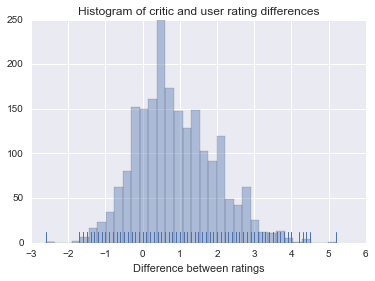

In [432]:
trd_plot = sns.distplot(trd_no_na["tomatoRatingDif"], kde=False, rug=True)
# Set the Title of the graph from here
trd_plot.axes.set_title('Histogram of critic and user rating differences')
# Set the xlabel of the graph from here
trd_plot.set_xlabel("Difference between ratings")
figure = trd_plot.get_figure()
figure.savefig("Rating difference histogram.png")

We can see that users generally rate movies higher than critics. 

**Let's make a mean plot for rating difference for the different genres**

[<matplotlib.text.Text at 0x124c1c090>, <matplotlib.text.Text at 0x114ac6c90>]

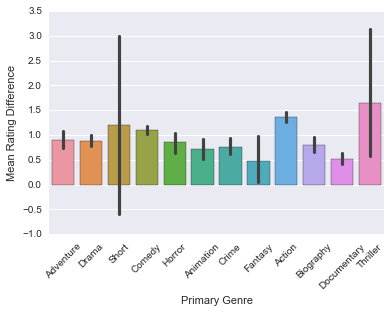

In [686]:
# only look at genres where at least 11 movies have that as their primary genre.
pop_genres = merged_movies
pop_genres = merged_movies[merged_movies.groupby('Primary_Genre').Primary_Genre.transform(len) > 10]
genre_plot = sns.barplot(x="Primary_Genre", y="tomatoRatingDif", data=pop_genres)
for item in genre_plot.get_xticklabels():
    item.set_rotation(45)
genre_plot.set(xlabel='Primary Genre', ylabel='Mean Rating Difference')

**Let's make a plot with rating difference by the movie rating**

In [583]:
# only interested in ratings that at least 11 movies have
pop_rated = merged_movies
pop_rated = merged_movies[merged_movies.groupby('Rated').Rated.transform(len) > 10]

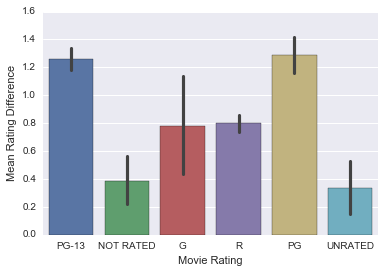

In [689]:
rated_plot = sns.barplot(x="Rated", y="tomatoRatingDif", data=pop_rated)
for item in genre_plot.get_xticklabels():
    item.set_rotation(45)
rated_plot.set(xlabel='Movie Rating', ylabel='Mean Rating Difference')
figure2 = rated_plot.get_figure()
figure2.savefig("Rating and Difference.png")

**Let's find which movie has the maximum difference and which has the minimum**

In [436]:
merged_movies.ix[merged_movies['tomatoRatingDif'].idxmax()]

Actors               Kevin Sorbo, Shane Harper, David A.R. White, D...
Awards                                                             NaN
Country                                                            USA
DVD                                                        05 Aug 2014
Director                                                  Harold Cronk
Genre                                                            Drama
Language                                                       English
Metascore                                                           16
Plot                 Radisson finds the topic of religion painful b...
Poster               http://ia.media-imdb.com/images/M/MV5BMjEwNDQ3...
Production                                     Pure Flix Entertainment
Rated                                                               PG
Released                                                   21 Mar 2014
Response                                                          True
Runtim

In [437]:
merged_movies.ix[merged_movies['tomatoRatingDif'].idxmin()]

Actors                                                             NaN
Awards                                                             NaN
Country                                                            USA
DVD                                                                NaN
Director                                                 Terry Sanders
Genre                                                 Documentary, War
Language                                                       English
Metascore                                                           64
Plot                 "Fighting for Life" follows American military ...
Poster               http://ia.media-imdb.com/images/M/MV5BMTIwNDYw...
Production                                                 Truly Indie
Rated                                                              NaN
Released                                                   01 Mar 2008
Response                                                          True
Runtim